# 準備

## Googleドライブのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [2]:
import sys
sys.path.append('/content/drive/My Drive/DNN_code')

# simple RNN
### バイナリ加算

iters:0
Loss:1.592313958307537
Pred:[1 1 1 1 1 1 1 1]
True:[0 0 1 1 0 0 0 0]
23 + 25 = 255
------------
iters:100
Loss:1.120778481405919
Pred:[0 0 0 1 0 0 0 1]
True:[0 0 0 0 1 1 1 0]
6 + 8 = 17
------------
iters:200
Loss:0.8984035840821232
Pred:[1 1 0 1 1 1 1 1]
True:[0 1 0 0 1 1 1 1]
34 + 45 = 223
------------
iters:300
Loss:1.0003793688497242
Pred:[1 0 1 0 0 1 0 1]
True:[1 1 0 1 0 1 0 0]
90 + 122 = 165
------------
iters:400
Loss:0.9763430757616574
Pred:[1 0 0 1 1 1 1 0]
True:[1 0 1 1 0 0 1 0]
71 + 107 = 158
------------
iters:500
Loss:1.0280648099146508
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 1 0 0 1 0]
124 + 54 = 0
------------
iters:600
Loss:1.01957088943565
Pred:[1 1 1 1 1 1 1 1]
True:[1 1 0 0 1 0 1 0]
127 + 75 = 255
------------
iters:700
Loss:1.0087138672215865
Pred:[0 0 0 0 1 0 1 0]
True:[1 0 1 1 1 0 0 1]
77 + 108 = 10
------------
iters:800
Loss:0.9343029958627398
Pred:[1 1 1 1 1 1 1 0]
True:[1 0 1 1 0 1 1 1]
117 + 66 = 254
------------
iters:900
Loss:1.0075841314875384
Pred:[0 1

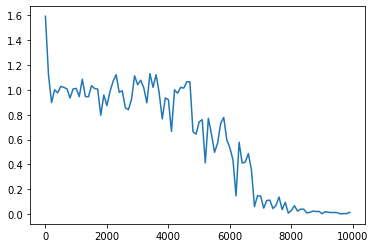

In [3]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

# def d_tanh(x):



# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 8
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier


# He



# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])

        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] weight_init_stdやlearning_rate, hidden_layer_sizeを変更してみよう




---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

iters:0
Loss:1.303256851078019
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 0 0 0 1 1]
110 + 21 = 0
------------
iters:100
Loss:0.7772971628473239
Pred:[0 0 1 0 1 0 1 1]
True:[0 0 1 0 1 1 1 1]
11 + 36 = 43
------------
iters:200
Loss:1.20852237742954
Pred:[0 0 0 0 0 1 0 1]
True:[0 1 1 1 0 0 1 0]
7 + 107 = 5
------------
iters:300
Loss:1.3971190217087737
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 1 0 0 0 1 0]
125 + 37 = 255
------------
iters:400
Loss:1.0350607319943388
Pred:[1 1 1 1 1 1 1 0]
True:[1 1 1 0 0 0 1 1]
117 + 110 = 254
------------
iters:500
Loss:1.162776096728742
Pred:[0 0 0 1 1 1 1 1]
True:[0 0 1 0 0 0 0 1]
31 + 2 = 31
------------
iters:600
Loss:0.9156973172195932
Pred:[0 0 1 0 1 0 0 0]
True:[0 1 0 1 1 0 1 0]
30 + 60 = 40
------------
iters:700
Loss:0.8988378085527498
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 0 0 1 1 1 1]
86 + 57 = 255
------------
iters:800
Loss:1.0318542371280006
Pred:[0 0 0 0 1 1 1 1]
True:[0 0 1 1 0 1 0 0]
39 + 13 = 15
------------
iters:900
Loss:0.8995239345626905
Pred:[1 0 0 0 

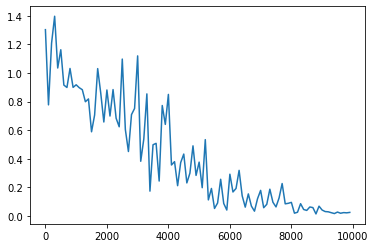

In [4]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

# def d_tanh(x):



# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 32
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.05

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier


# He



# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])

        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

iters:0
Loss:2.174293770836696
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 1 0 1 1 0]
74 + 108 = 0
------------
iters:100
Loss:1.0064718047007344
Pred:[0 1 0 0 0 1 0 0]
True:[0 1 1 1 0 0 1 0]
44 + 70 = 68
------------
iters:200
Loss:1.1020839127055944
Pred:[0 0 0 1 1 1 0 1]
True:[0 1 1 0 1 0 1 0]
77 + 29 = 29
------------
iters:300
Loss:0.9975968950756293
Pred:[0 0 0 1 0 1 0 1]
True:[0 1 1 0 0 0 0 1]
9 + 88 = 21
------------
iters:400
Loss:0.9286502657458573
Pred:[1 0 0 1 0 1 1 1]
True:[1 0 0 1 1 1 0 0]
67 + 89 = 151
------------
iters:500
Loss:0.9182445301868937
Pred:[1 1 1 0 1 1 1 1]
True:[0 1 1 1 1 0 1 1]
55 + 68 = 239
------------
iters:600
Loss:0.8719683401579325
Pred:[1 1 0 0 0 1 1 0]
True:[1 1 0 1 1 1 1 1]
123 + 100 = 198
------------
iters:700
Loss:0.9484808314456157
Pred:[0 0 0 0 0 1 0 0]
True:[0 1 1 0 0 0 0 0]
22 + 74 = 4
------------
iters:800
Loss:0.8343317803447365
Pred:[1 1 1 0 0 1 0 0]
True:[0 1 1 1 0 1 0 0]
82 + 34 = 228
------------
iters:900
Loss:0.9024645847050567
Pred:[1 1 0

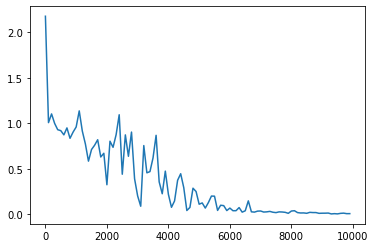

In [5]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

# def d_tanh(x):



# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier


# He



# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])

        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

iters:0
Loss:2.4231323008014085
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 1 1 1 0 0]
83 + 41 = 0
------------
iters:100
Loss:1.2613246957524715
Pred:[0 0 0 0 0 0 1 0]
True:[1 0 0 1 1 0 1 0]
100 + 54 = 2
------------
iters:200
Loss:0.8566240540787575
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 0 0 0 0 0]
58 + 102 = 0
------------
iters:300
Loss:1.0174944285762684
Pred:[1 0 1 1 1 1 1 0]
True:[0 1 1 0 1 1 0 0]
34 + 74 = 190
------------
iters:400
Loss:2.4038445161878244
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 1 0 0 0 0 1]
38 + 123 = 255
------------
iters:500
Loss:0.5259236206880525
Pred:[1 0 1 1 1 1 1 0]
True:[1 0 1 1 0 1 1 0]
76 + 106 = 190
------------
iters:600
Loss:0.6708190624738155
Pred:[0 1 1 1 1 1 1 1]
True:[0 0 1 1 1 1 0 1]
28 + 33 = 127
------------
iters:700
Loss:0.5235275781396909
Pred:[0 1 1 0 0 0 1 1]
True:[0 1 1 1 0 0 1 1]
18 + 97 = 99
------------
iters:800
Loss:1.0478968753649218
Pred:[0 1 1 1 1 1 1 0]
True:[0 0 1 0 1 1 1 0]
7 + 39 = 126
------------
iters:900
Loss:0.6809917696068717
Pred:[0 0

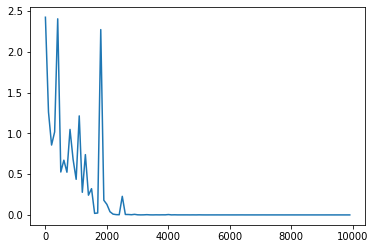

In [6]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

# def d_tanh(x):



# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 64
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.5

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier


# He



# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])

        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

## [try] 重みの初期化方法を変更してみよう
Xavier, He



iters:0
Loss:1.0324651317336313
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 1 0 1 0 0]
38 + 78 = 0
------------
iters:100
Loss:1.0932923768779363
Pred:[0 1 0 0 1 1 0 0]
True:[1 0 1 1 0 0 1 0]
76 + 102 = 76
------------
iters:200
Loss:0.9995535281209313
Pred:[0 1 0 0 0 0 1 1]
True:[1 1 0 0 0 1 1 0]
75 + 123 = 67
------------
iters:300
Loss:1.0048384520910634
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 0 0 1 0 1]
105 + 60 = 0
------------
iters:400
Loss:1.0863354814306732
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 1 1 0 0 1]
98 + 23 = 0
------------
iters:500
Loss:1.0037473819205909
Pred:[1 0 1 1 1 1 1 1]
True:[1 1 0 0 0 0 1 1]
100 + 95 = 191
------------
iters:600
Loss:0.9764827457355405
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 1 1 0 1 1 0]
55 + 127 = 255
------------
iters:700
Loss:0.9911195624186804
Pred:[0 0 0 0 0 0 0 0]
True:[1 1 0 1 1 0 0 0]
116 + 100 = 0
------------
iters:800
Loss:0.9670426521899007
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 1 0 0 1 0]
101 + 45 = 0
------------
iters:900
Loss:1.0279428742004386
Pred:[1 1

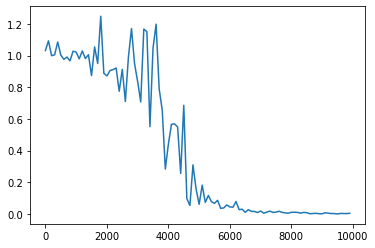

In [7]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

# def d_tanh(x):



# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))

# He



# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])

        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

iters:0
Loss:0.9766977969763198
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 1 1 0 0 0]
72 + 16 = 0
------------
iters:100
Loss:1.0253048322320604
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 1 1 0 1 0]
104 + 82 = 0
------------
iters:200
Loss:0.9770669204300746
Pred:[1 1 1 1 1 1 1 0]
True:[1 0 1 0 1 0 1 0]
64 + 106 = 254
------------
iters:300
Loss:0.9676637818428953
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 0 1 0 1 1 1]
114 + 37 = 255
------------
iters:400
Loss:1.006376172394762
Pred:[1 1 1 1 1 1 1 1]
True:[0 0 1 1 0 0 1 0]
17 + 33 = 255
------------
iters:500
Loss:1.0676105970316043
Pred:[0 1 1 1 0 0 0 1]
True:[1 0 1 0 0 1 1 0]
53 + 113 = 113
------------
iters:600
Loss:1.0418924658371054
Pred:[1 1 1 1 0 0 1 1]
True:[1 1 0 1 0 1 0 0]
113 + 99 = 243
------------
iters:700
Loss:0.8865267712736125
Pred:[0 1 0 0 0 1 0 0]
True:[0 1 0 1 0 0 0 0]
46 + 34 = 68
------------
iters:800
Loss:0.9817685375295659
Pred:[1 1 1 1 1 1 1 1]
True:[0 0 1 0 0 0 1 1]
17 + 18 = 255
------------
iters:900
Loss:1.0823725483859217
Pred:[

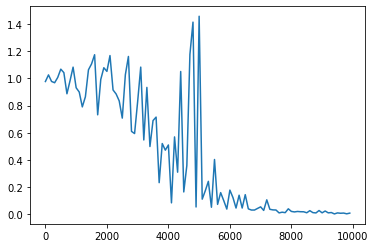

In [8]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

# def d_tanh(x):



# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier


# He
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])

        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

## [try] 中間層の活性化関数を変更してみよう
ReLU(勾配爆発を確認しよう)<br>
tanh(numpyにtanhが用意されている。導関数をd_tanhとして作成しよう)

/content/drive/My Drive/DNN_code/common/functions.py:6: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


iters:0
Loss:0.9157630121476878
Pred:[0 0 0 1 1 1 1 0]
True:[0 0 1 1 1 1 0 0]
6 + 54 = 30
------------
iters:100
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 1 0 1 0 0]
111 + 37 = 0
------------
iters:200
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 1 1 0 0 0]
44 + 108 = 0
------------
iters:300
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 1 1 0 1 1 1]
22 + 33 = 0
------------
iters:400
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 1 1 0 0 0]
82 + 38 = 0
------------
iters:500
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 1 1 1 0 0]
123 + 33 = 0
------------
iters:600
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 1 1 1 0 1]
118 + 7 = 0
------------
iters:700
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 1 1 1 1 0 0]
54 + 6 = 0
------------
iters:800
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 0 0 0 1 1]
100 + 63 = 0
------------
iters:900
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 1 0 1 0 1 0]
10 + 32 = 0
------------
iters:1000
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 1 1 1 0 0 0]
30 + 26 = 0
------

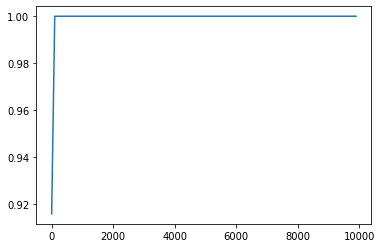

In [9]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)



# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        #z[:,t+1] = functions.sigmoid(u[:,t+1])
        z[:,t+1] = functions.relu(u[:,t+1])
#         z[:,t+1] = np.tanh(u[:,t+1])    
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])    

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

iters:0
Loss:2.1240955426252484
Pred:[1 0 0 1 0 0 0 1]
True:[0 1 1 1 1 0 1 0]
105 + 17 = 145
------------
iters:100
Loss:1.3393746703342784
Pred:[1 0 1 0 1 1 1 0]
True:[0 1 0 0 0 1 0 1]
62 + 7 = 174
------------
iters:200
Loss:0.7988403171821444
Pred:[0 1 1 0 1 0 1 1]
True:[0 1 1 0 1 1 1 1]
107 + 4 = 107
------------
iters:300
Loss:1.3576475195908266
Pred:[0 1 0 1 0 1 0 1]
True:[1 0 0 1 1 1 0 0]
37 + 119 = 85
------------
iters:400
Loss:1.376229207626363
Pred:[0 1 0 1 1 1 0 0]
True:[1 0 1 0 0 1 0 0]
92 + 72 = 92
------------
iters:500
Loss:0.9630768767932595
Pred:[1 0 1 1 1 1 0 0]
True:[0 0 1 0 1 0 0 0]
23 + 17 = 188
------------
iters:600
Loss:1.2117969914943991
Pred:[1 0 1 0 1 0 1 0]
True:[0 0 1 0 0 1 0 0]
3 + 33 = 170
------------
iters:700
Loss:1.0399204070030232
Pred:[0 1 0 1 0 1 1 1]
True:[0 1 1 1 1 0 0 1]
67 + 54 = 87
------------
iters:800
Loss:1.1339297522354794
Pred:[1 0 0 1 0 1 0 1]
True:[1 0 1 0 1 0 0 1]
97 + 72 = 149
------------
iters:900
Loss:0.8904735272546465
Pred:[1 0

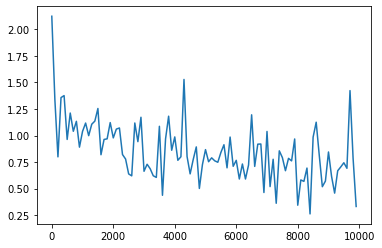

In [10]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)



# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
       # z[:,t+1] = functions.sigmoid(u[:,t+1])
#         z[:,t+1] = functions.relu(u[:,t+1])
        z[:,t+1] = np.tanh(u[:,t+1])    
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])    

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()